In [1]:
import numpy as np
import struct
import random
import matplotlib.pyplot as plt

def load_data(images_filepath, labels_filepath):
    labels = np.fromfile(labels_filepath, np.uint8, offset=8)
    with open(images_filepath, 'rb') as file:
        _, size, _, _ = struct.unpack(">IIII", file.read(16))
    images = np.fromfile(images_filepath, np.uint8, offset=16).reshape(size, 784)
    return np.array(images), np.array(labels)

train_images_filepath = 'data/train-images.idx3-ubyte'
train_labels_filepath = 'data/train-labels.idx1-ubyte'
test_images_filepath = 'data/t10k-images.idx3-ubyte'
test_labels_filepath = 'data/t10k-labels.idx1-ubyte'

x_train, y_train = load_data(train_images_filepath, train_labels_filepath)
x_test, y_test = load_data(test_images_filepath, test_labels_filepath)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 784)

(60000,)

(10000, 784)

(10000,)


In [1]:
 "!cp -r /kaggle/input/predict-student-performance-from-game-play /kaggle/working/"

'!cp -r /kaggle/input/predict-student-performance-from-game-play /kaggle/working/'

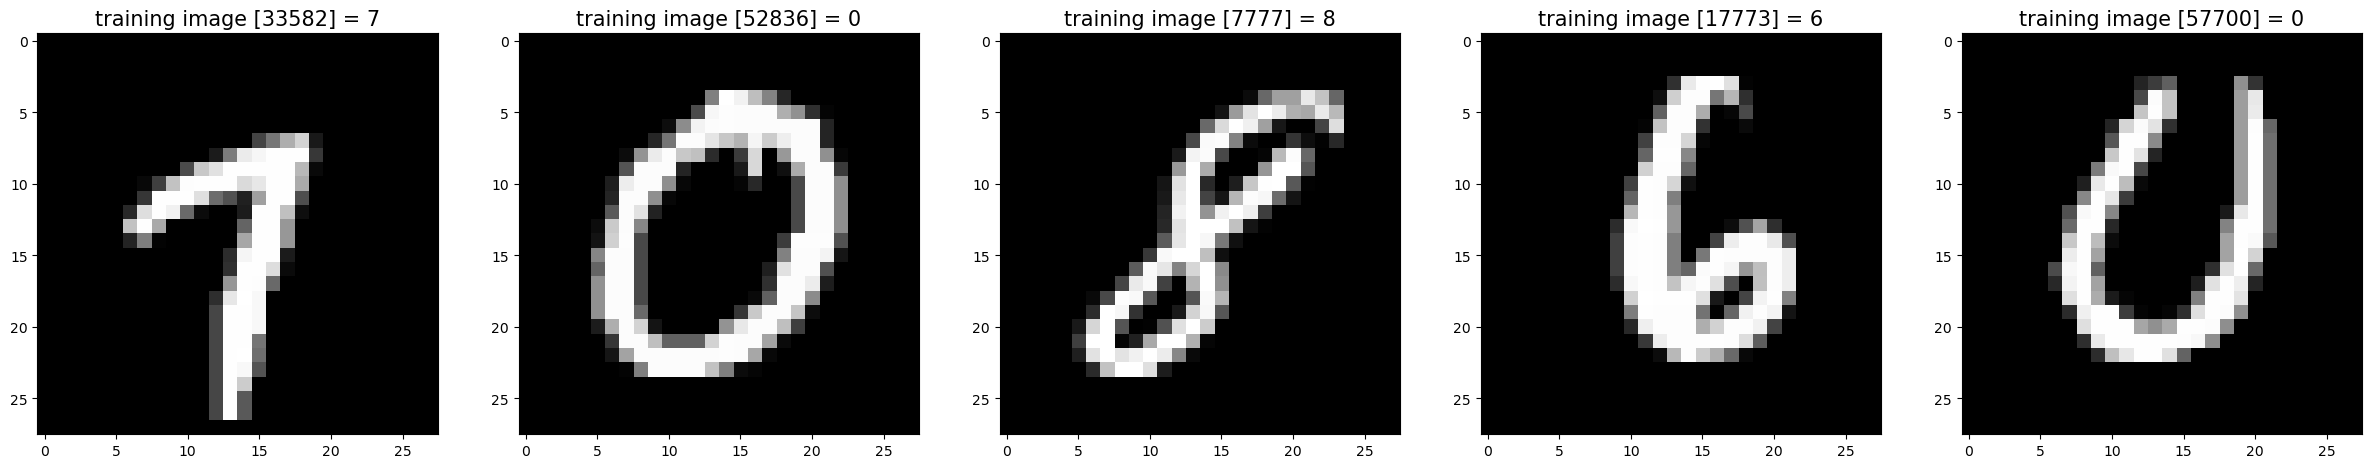

In [2]:
def show_images(images, titles):
    cols = 5
    rows = len(images) // cols + 1
    plt.figure(figsize=(30, 20))
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap=plt.cm.gray)
        plt.title(title, fontsize=15)

images, titles = [], []
for i in range(0, 5):
    r = random.randint(1, 60000)
    images.append(x_train[r].reshape(28, 28))
    titles.append(f'training image [{r}] = {y_train[r]}')

show_images(images, titles)

In [3]:
from sklearn.cluster import KMeans
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x_train)
cluster_assignments = kmeans.labels_
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(y_train, cluster_assignments)
print(f"Adjusted Rand Index (ARI): {ari}")


/home/thinker/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

  warnings.warn(


Adjusted Rand Index (ARI): 0.36073100330284136


In [10]:
# Calculate the Euclidean distance between each data point and the centroid of its assigned cluster
distances = []
for i in range(k):
    cluster_points = x_train[cluster_assignments == i]
    centroid = kmeans.cluster_centers_[i]
    cluster_distances = np.sum((cluster_points - centroid) ** 2, axis=1)
    distances.extend(cluster_distances)

# Calculate the average within-cluster sum of squares (j)
j = np.mean(distances) / len(x_train)
print(f"Average Within-Cluster Sum of Squares (j): {j}")


Average Within-Cluster Sum of Squares (j): 42.49793897950399


In [17]:
from sklearn.metrics import pairwise_distances

centroid_distances = pairwise_distances(kmeans.cluster_centers_, metric='euclidean')

db_index = 0
for i in range(k):
    max_ratio = 0
    for j in range(k):
        if i != j:
            ratio = (distances[i] + distances[j]) / centroid_distances[i, j]
            if ratio > max_ratio:
                max_ratio = ratio
    db_index += max_ratio

db_index /= k
print(f"Davies–Bouldin Index: {db_index}")


Davies–Bouldin Index: 3137.304718289147


In [12]:
min_intra_cluster_distances = []
for i in range(k):
    cluster_points = x_train[cluster_assignments == i]
    pairwise_distances_cluster = pairwise_distances(cluster_points, metric='euclidean')
    np.fill_diagonal(pairwise_distances_cluster, np.inf)  # Set diagonal to infinity to exclude self-distances
    min_intra_cluster_distances.append(np.min(pairwise_distances_cluster))

max_inter_cluster_distance = np.max(centroid_distances)

dunn_index = min(min_intra_cluster_distances) / max_inter_cluster_distance
print(f"Dunn Index: {dunn_index}")


Dunn Index: 0.1025221651353268


In [13]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_train, cluster_assignments)

purity = np.sum(np.max(confusion, axis=0)) / len(y_train)
print(f"Purity: {purity}")


Purity: 0.5909


In [14]:
from sklearn.metrics import adjusted_rand_score

# Calculate the Rand index
rand_index = adjusted_rand_score(y_train, cluster_assignments)
print(f"Rand Index: {rand_index}")


Rand Index: 0.36073100330284136


In [ ]:
pip install plotly

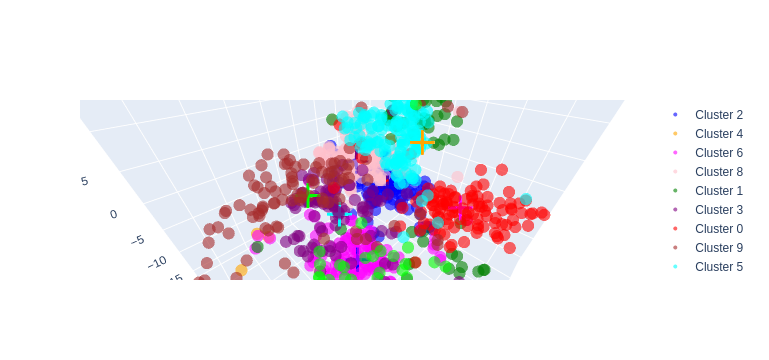

In [18]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

random_indices = np.random.choice(len(x_train), 1000, replace=False)
subset_data = x_train[random_indices]
subset_assignments = cluster_assignments[random_indices]

tsne = TSNE(n_components=3, random_state=42)
tsne_results = tsne.fit_transform(subset_data)

df = pd.DataFrame({
    'x': tsne_results[:, 0],
    'y': tsne_results[:, 1],
    'z': tsne_results[:, 2],
    'cluster': subset_assignments
})

fig = go.Figure()

centroids = []
for cluster in df['cluster'].unique():
    cluster_data = df[df['cluster'] == cluster]
    centroid = cluster_data[['x', 'y', 'z']].mean().values
    centroids.append(centroid)

centroids = np.array(centroids)

cluster_colors = {
    0: 'red',
    1: 'green',
    2: 'blue',
    3: 'purple',
    4: 'orange',
    5: 'cyan',
    6: 'magenta',
    7: 'lime',
    8: 'pink',
    9: 'brown'
}

marker_size = 4

for cluster in df['cluster'].unique():
    cluster_data = df[df['cluster'] == cluster]
    fig.add_trace(go.Scatter3d(
        x=cluster_data['x'],
        y=cluster_data['y'],
        z=cluster_data['z'],
        mode='markers',
        marker=dict(
            size=marker_size,
            opacity=0.6,
            color=cluster_colors[cluster],  
        ),
        name=f'Cluster {cluster}'  
    ))

centroid_marker_size = 10

for cluster in df['cluster'].unique():
    centroid = centroids[cluster]
    fig.add_trace(go.Scatter3d(
        x=[centroid[0]],
        y=[centroid[1]],
        z=[centroid[2]],
        mode='markers',
        marker=dict(
            size=centroid_marker_size,
            opacity=1.0,
            symbol='cross',
            color=cluster_colors[cluster],  
        ),
        name=f'Centroid {cluster}'
    ))

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    )
)

fig.show()
